# Imports and Functions

In [1]:
from sunlab.environment.base.cpu import *
from sunlab.environment.base.extras import *
from sunlab.globals import FILES
from sunlab.sunflow import *

In [2]:
def proximity_to(dest_arr, src, R=0.15):
    assert src.shape[-1] == dest_arr.shape[-1], f"Shape Mismatch! {src.shape}, {dest_arr.shape}"
    arrs = []
    for row in dest_arr:
        if np.linalg.norm(src-row) < R:
            arrs.append(row)
    return np.array(arrs)

def dotProduct(a,b, norm=False, axis=-1):
    if norm:
        return np.sum(a*b,axis=axis)/(np.linalg.norm(a,axis=axis)*np.linalg.norm(b,axis=axis))
    return np.sum(a*b, axis=axis)

def DistanceCovariance(model, mfv_dataset, labels=None, shuffle=False, silent=False):
    """# Distance Covariance
    Compute the distance in the MFS and MLS
    - mfv_dataset: (N,13)
    - labels: (N,...) ?"""
    from numpy import vstack, array
    from numpy.linalg import norm
    from tqdm.auto import tqdm
    assert mfv_dataset.shape[1] == 13
    if labels is None:
        neighborhood_labels = None
    else:
        assert labels.shape[0] == mfv_dataset.shape[0]
        neighborhood_labels = []
    neighborhood_distances = []
    progress = tqdm
    if silent:
        progress = lambda x: x
    for cell_index in progress(range(mfv_dataset.shape[0])):
        source_cell = mfv_dataset[[cell_index],:]
        destination_cells = vstack([mfv_dataset[:cell_index,:], mfv_dataset[(cell_index+1):,:]])
        mfv_distance = norm((destination_cells - source_cell), axis=-1)
        mlv_distance = norm((model.encoder(destination_cells)-model.encoder(source_cell)), axis=-1)
        v_distances = list(zip(mfv_distance, mlv_distance))
        if labels is not None:
            neighborhood_labels.extend([labels[cell_index,...]] * len(v_distances))
        for distance in v_distances:
            neighborhood_distances.append(distance)
    neighborhood_distances = array(neighborhood_distances)
    if labels is not None:
        neighborhood_labels = array(neighborhood_labels)
    if shuffle:
        from numpy.random import permutation as permute
        permutation = permute(neighborhood_distances.shape[0])
        neighborhood_distances = neighborhood_distances[permutation,...]
        if labels is not None:
            neighborhood_labels = neighborhood_labels[permutation,...]
    return neighborhood_distances, neighborhood_labels

def AngleCovariance(model, mfv_dataset, labels=None, filter_R=0.15, shuffle=False, silent=False):
    """# Angular Covariance
    Compute the angular mapping in the MFS and MLS
    - mfv_dataset: (N,13)
    - labels: (N,...) ?"""
    from numpy import vstack, array, ones_like
    from numpy.linalg import norm
    from tqdm.auto import tqdm
    assert mfv_dataset.shape[1] == 13
    if labels is None:
        neighborhood_labels = None
    else:
        assert labels.shape[0] == mfv_dataset.shape[0]
        neighborhood_labels = []
    neighborhood_dot_products = []
    progress = tqdm
    if silent:
        progress = lambda x: x
    for cell_index in progress(range(mfv_dataset.shape[0])):
        source_cell = mfv_dataset[[cell_index],:]
        for middle_cell_index in range(cell_index+1,mfv_dataset.shape[0]):
            middle_cell = mfv_dataset[[middle_cell_index],:]
            if norm((middle_cell - source_cell)) > filter_R:
                continue
            middle_cell_mlv = model.encoder(middle_cell)
            destination_cells = mfv_dataset[(middle_cell_index+1):,:]
            destination_cells = proximity_to(destination_cells, middle_cell, R=filter_R)
            if destination_cells.shape[0] == 0:
                continue
            comparison_vector = ones_like(destination_cells) * (middle_cell - source_cell)
            source_cell_stacks_mlv = model.encoder(ones_like(destination_cells) * source_cell).numpy()
            destination_cells_mlv = model.encoder(destination_cells).numpy()
            mfv_dot = dotProduct(comparison_vector, (destination_cells - middle_cell), axis=-1, norm=True)
            mlv_dot = dotProduct(middle_cell_mlv - source_cell_stacks_mlv,
                                 destination_cells_mlv - middle_cell_mlv, axis=-1, norm=True)
            v_dot_products = list(zip(mfv_dot, mlv_dot))
            if labels is not None:
                neighborhood_labels.extend([labels[cell_index,...]] * len(v_dot_products))
            for dot_product in v_dot_products:
                neighborhood_dot_products.append(dot_product)
    neighborhood_dot_products = array(neighborhood_dot_products)
    if labels is not None:
        neighborhood_labels = array(neighborhood_labels)
    if shuffle:
        from numpy.random import permutation as permute
        permutation = permute(neighborhood_dot_products.shape[0])
        neighborhood_dot_products = neighborhood_dot_products[permutation,...]
        if labels is not None:
            neighborhood_labels = neighborhood_labels[permutation,...]
    return np.arccos(neighborhood_dot_products), neighborhood_labels

In [3]:
def p_hypersphere_sample(sample_s, labels=None, N=4, distance=1, include_original=True):
    """# Star Sample
    sample(s): (M?,D)
    N: Number of samples"""
    from numpy import newaxis, vstack, repeat, array, ndarray
    from numpy.random import randn
    from numpy.linalg import norm
    if not isinstance(sample_s, ndarray):
        sample_s = array(sample_s)
    if labels is not None:
        if not isinstance(labels, ndarray):
            labels = array(labels)
    dim = sample_s.shape[-1]
    if len(sample_s.shape) == 1:
        sample_s = sample_s[newaxis,...]
    M = sample_s.shape[0]
    sample = []
    for m in range(M):
        subsample = []
        d = randn(N,dim)
        d = (d.T/norm(d, axis=-1)).T
        d *= distance
        subsample.append(sample_s[m,...] + d)
        # Idea: Generate 2 points, then sample from the AOB plane in a circle around O starting at A?
#         for n in range(N):
#             d = randn(dim)
#             d /= norm(d)
#             d *= distance
#             subsample.append(sample_s[m,...] + d)
        if include_original:
            subsample.append(sample_s[m,...])
        subsample_data = vstack(subsample)[newaxis,...]
        subsample_labels = None
        if labels is not None:
            subsample_labels = repeat(labels[[m],...],subsample_data.shape[1], axis=0)
            if len(subsample_labels.shape) == 1:
                subsample_labels = subsample_labels.reshape((1,-1,1))
            elif len(subsample_labels.shape) == 2:
                subsample_labels = subsample_labels.reshape((1,subsample_labels.shape[0],subsample_labels.shape[1]))
        sample.append((subsample_data,subsample_labels))
    sample_data = vstack(list(map(lambda x: x[0], sample)))
    if labels is not None:
        sample_labels = vstack(list(map(lambda x: x[1], sample)))
        return sample_data, sample_labels
    return sample_data

In [4]:
def span_subspace(o,x,y,N=4, jitter=0, check=False):
    from numpy.linalg import norm
    from numpy import dot, linspace, vstack, sin, cos, pi
    from numpy.random import rand
    _o = o
    _d1 = x
    _d2 = y
    _x1 = _d1 - _o
    _x2 = _d2 - _o
    _x1 /= norm(_x1)
    _x2 /= norm(_x2)
    # _x2 = np.cross(_x1, np.cross(_x1, _x2))
    _x2 = _x2 - dot(_x1,_x2) * _x1
    _x1 /= norm(_x1)
    _x2 /= norm(_x2)
    R = vstack([_x1,_x2])
    _t = linspace(0,2*pi,N,endpoint=False) + rand(N)*jitter
    _c = vstack([sin(_t),cos(_t)])
    _s = (R.T@_c).T
    if check:
        print(dot(_x1, _x2))
    return _s

In [5]:
_o = np.array([1,1,1]).astype(np.double)
_d1 = np.array([0,0,1]).astype(np.double)
_d2 = np.array([0,1,0]).astype(np.double)
span_subspace(_o,_d1,_d2, check=True)

5.551115123125783e-17


array([[-4.08248290e-01,  4.08248290e-01, -8.16496581e-01],
       [-7.07106781e-01, -7.07106781e-01, -4.99959962e-17],
       [ 4.08248290e-01, -4.08248290e-01,  8.16496581e-01],
       [ 7.07106781e-01,  7.07106781e-01,  1.49987989e-16]])

In [6]:
def n_circle_sample(sample_s, labels=None, N=4, distance=1, include_original=True, jitter=0.1):
    """# Star Sample
    sample(s): (M?,D)
    N: Number of samples"""
    from numpy import newaxis, vstack, repeat, array, ndarray
    from numpy.random import randn
    from numpy.linalg import norm
    if not isinstance(sample_s, ndarray):
        sample_s = array(sample_s)
    if labels is not None:
        if not isinstance(labels, ndarray):
            labels = array(labels)
    dim = sample_s.shape[-1]
    if len(sample_s.shape) == 1:
        sample_s = sample_s[newaxis,...]
    M = sample_s.shape[0]
    sample = []
    for m in range(M):
        subsample = []
        d1 = randn(dim)
        d2 = randn(dim)
        sample_d = distance*span_subspace(sample_s[m,...], d1, d2, N=N, jitter=jitter)
        subsample.append(sample_s[m,...] + sample_d)
        # Idea: Generate 2 points, then sample from the AOB plane in a circle around O starting at A?
#         for n in range(N):
#             d = randn(dim)
#             d /= norm(d)
#             d *= distance
#             subsample.append(sample_s[m,...] + d)
        if include_original:
            subsample.append(sample_s[m,...])
        subsample_data = vstack(subsample)[newaxis,...]
        subsample_labels = None
        if labels is not None:
            subsample_labels = repeat(labels[[m],...],subsample_data.shape[1], axis=0)
            if len(subsample_labels.shape) == 1:
                subsample_labels = subsample_labels.reshape((1,-1,1))
            elif len(subsample_labels.shape) == 2:
                subsample_labels = subsample_labels.reshape((1,subsample_labels.shape[0],subsample_labels.shape[1]))
        sample.append((subsample_data,subsample_labels))
    sample_data = vstack(list(map(lambda x: x[0], sample)))
    if labels is not None:
        sample_labels = vstack(list(map(lambda x: x[1], sample)))
        return sample_data, sample_labels
    return sample_data

In [7]:
def star_sample(sample_s, labels=None, N=4, distance=1, include_original=True):
    """# Star Sample
    sample(s): (M?,D=2)
    N: Number of samples"""
    from numpy import pi, sin, cos, array, vstack, repeat
    assert sample_s.shape[-1] == 2
    theta = 2*pi/N
    d = distance * vstack([array([(sin(theta * n), cos(theta * n)) for n in range(N)])])
    
    if len(sample_s.shape) == 1:
        data = (sample_s + d)
        if include_original:
            data = vstack([data, sample_s])
        if labels is None:
            return data[np.newaxis,...]
        return data[np.newaxis,...]
    elif sample_s.shape[0] == 1:
        data = (sample_s[0,...] + d)
        if include_original:
            data = vstack([data, sample_s[0,...]])
        if labels is None:
            return data[np.newaxis,...]
        return data[np.newaxis,...]
    else:
        stars = []
        labeled = []
        for m in range(sample_s.shape[0]):
            if include_original:
                data = sample_s[m,...] + d
                data = vstack([data,sample_s[m,...]])
                stars.append(data[np.newaxis,...])
            else:
                stars.append((sample_s[m,...] + d)[np.newaxis,...])
            if labels is not None:
                sample_label = labels[[m],...]
                label_count = N
                if include_original:
                    label_count += 1
                labeled.append(repeat(sample_label, label_count)[np.newaxis,...])
        data = vstack(stars)
        if labels is not None:
            labeled = np.vstack(labeled)
            if len(labeled.shape) == 2:
                labeled = labeled[...,np.newaxis]
            return data, labeled
        return data

# Runtime Parameters

In [8]:
SAVE_EXTRAS = False

In [9]:
g_Base = lambda *args: DIR_ROOT + "Figures/Invasion/Spheroid/Sampled/Infinitesimal/"

# Setup

In [10]:
g_N_Sampled = 9
g_d_Sampled = 5e-2#5e-2
g_o_Sampled = False

In [11]:
g_permute_max = lambda x: np.min([50000, x.shape[0]])

In [12]:
model = load_aae(FILES['PRETRAINED_MODEL_DIR'], MaxAbsScaler)

In [13]:
sampled_data = np.load_dat(FILES['FIGURES']['3']['SAMPLED_DATASET'])
sampled_dataset = sampled_data['dataset']
sampled_labels = sampled_data['labels']

# Hypersphere Circular Sample Along Random Plane

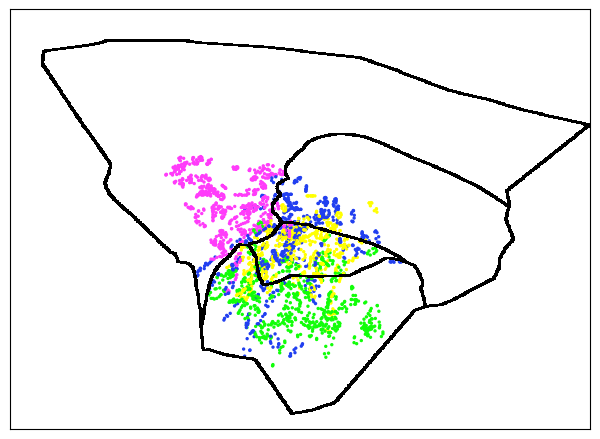

In [14]:
resampled_dataset, resampled_labels = n_circle_sample(sampled_dataset, sampled_labels, N=g_N_Sampled, distance=g_d_Sampled, include_original=g_o_Sampled, jitter=1e0)
resampled_latent = model.encoder(resampled_dataset).numpy()
plt.scatter2d(resampled_latent.reshape((-1,2)), c=resampled_labels.reshape((-1)), cmap=Pmap, s=2)
plt.apply_boundary()
if SAVE_EXTRAS:
    plt.save(g_Base() + "MfvCircleSample/Latent")

In [15]:
resampled_dataset.shape

(320, 9, 13)

In [16]:
infinitesimal_distances = []
infinitesimal_labels = []
for m in tqdm(range(resampled_dataset.shape[0])):
    distance, labels = DistanceCovariance(model, resampled_dataset[m], resampled_labels[m], shuffle=True, silent=True)
    infinitesimal_distances.append(distance)
    infinitesimal_labels.append(labels)
infinitesimal_distances = np.vstack(infinitesimal_distances)
infinitesimal_di_labels = np.vstack(infinitesimal_labels)
infinitesimal_distances.shape

  0%|          | 0/320 [00:00<?, ?it/s]

(23040, 2)

In [17]:
infinitesimal_dots = []
infinitesimal_labels = []
for m in tqdm(range(resampled_dataset.shape[0])):
    dots, labels = AngleCovariance(model, resampled_dataset[m], resampled_labels[m], shuffle=True, silent=True)
    infinitesimal_dots.append(dots)
    infinitesimal_labels.append(labels)
infinitesimal_dots = np.vstack(infinitesimal_dots)
infinitesimal_do_labels = np.vstack(infinitesimal_labels)
infinitesimal_dots.shape

  0%|          | 0/320 [00:00<?, ?it/s]

(26880, 2)

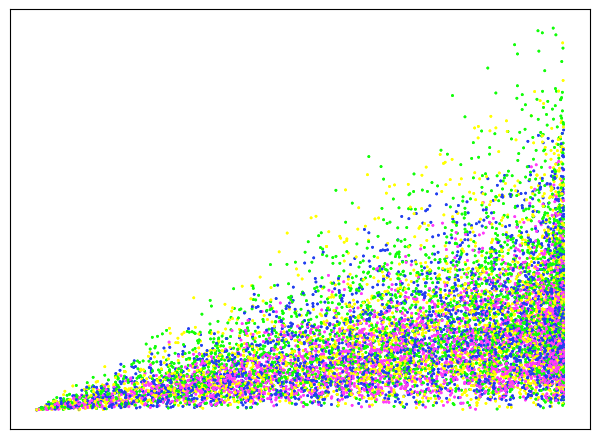

In [18]:
plt.scatter2d(infinitesimal_distances, c=infinitesimal_di_labels, cmap=Pmap, s=1)
if SAVE_EXTRAS:
    plt.save(g_Base() + "MfvCircleSample/InfinitesimalDistances")

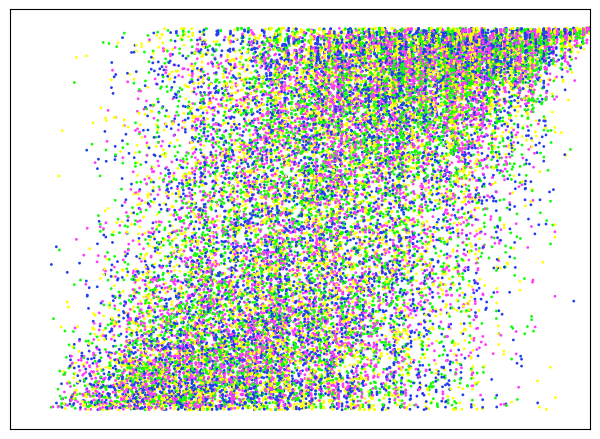

In [19]:
plt.scatter2d(infinitesimal_dots, c=infinitesimal_do_labels, cmap=Pmap, s=1)
plt.xlim([0,np.pi])
if SAVE_EXTRAS:
    plt.save(g_Base() + "MfvCircleSample/InfinitesimalAngles")

In [20]:
all_resampled_dataset = resampled_dataset.reshape((-1,13))
all_resampled_labels = resampled_labels.reshape((-1))
all_infinitesimal_distances, all_infinitesimal_labels = DistanceCovariance(model, all_resampled_dataset, all_resampled_labels, shuffle=True)

  0%|          | 0/2880 [00:00<?, ?it/s]

In [21]:
all_infinitesimal_distances.shape

(8291520, 2)

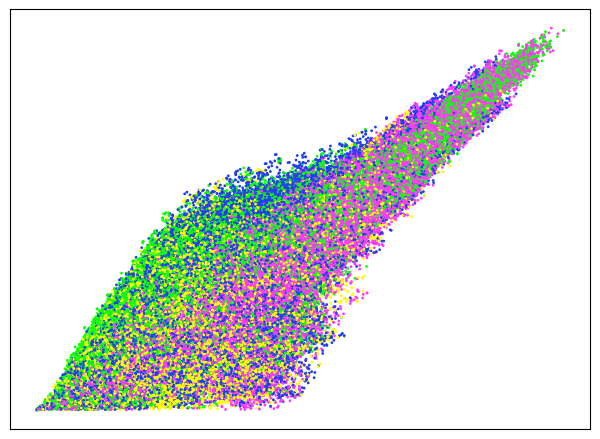

In [23]:
permutation = np.random.permutation(all_infinitesimal_distances.shape[0])
permutation = permutation[:permutation.shape[0]//10]
plt.scatter2d(all_infinitesimal_distances[permutation], c=all_infinitesimal_labels[permutation], cmap=Pmap, s=1)
_ = _
if SAVE_EXTRAS:
    plt.save(g_Base() + "MfvCircleSample/Distances")

In [24]:
all_infinitesimal_dots, all_infinitesimal_labels_do = AngleCovariance(model, all_resampled_dataset, all_resampled_labels, filter_R=2.01*g_d_Sampled, shuffle=True)

  0%|          | 0/2880 [00:00<?, ?it/s]

/tmp/4103233.6.sun-gpu.q/ipykernel_23558/659413713.py:102: RuntimeWarning: invalid value encountered in arccos
  return np.arccos(neighborhood_dot_products), neighborhood_labels


In [25]:
all_infinitesimal_dots.shape

(372391, 2)

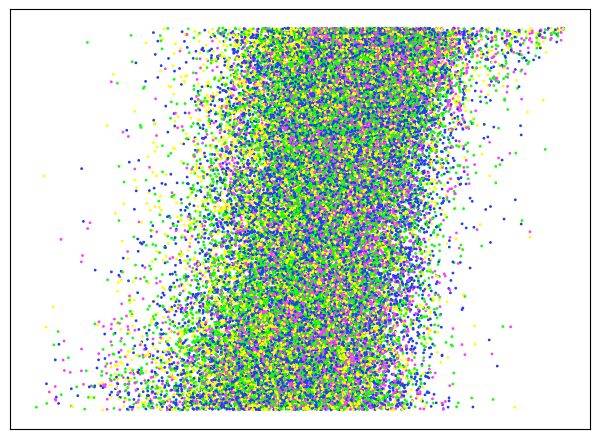

In [27]:
permutation = np.random.permutation(all_infinitesimal_dots.shape[0])
permutation = permutation[:g_permute_max(permutation)]
plt.scatter2d(all_infinitesimal_dots[permutation], c=all_infinitesimal_labels_do[permutation], cmap=Pmap, s=1)
_ = _
if SAVE_EXTRAS:
    plt.save(g_Base() + "MfvCircleSample/Angles")

# MFV Hypersphere Sample

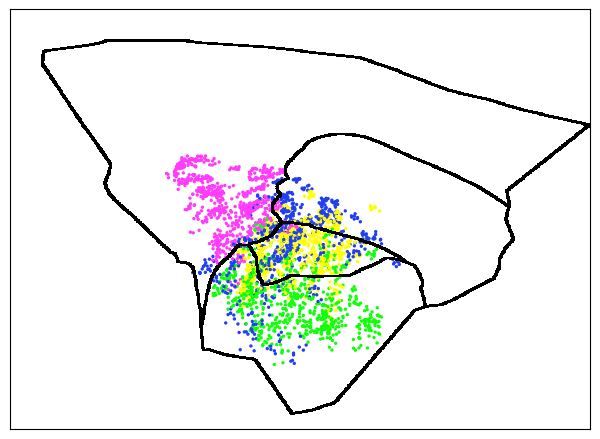

In [28]:
resampled_dataset, resampled_labels = p_hypersphere_sample(sampled_dataset, sampled_labels, N=g_N_Sampled, distance=g_d_Sampled, include_original=g_o_Sampled)
resampled_latent = model.encoder(resampled_dataset).numpy()
plt.scatter2d(resampled_latent.reshape((-1,2)), c=resampled_labels.reshape((-1)), cmap=Pmap, s=2)
plt.apply_boundary()
if SAVE_EXTRAS:
    plt.save(g_Base() + "MfvHypersphereSample/Latent")

In [29]:
resampled_dataset.shape

(320, 9, 13)

In [30]:
infinitesimal_distances = []
infinitesimal_labels = []
for m in tqdm(range(resampled_dataset.shape[0])):
    distance, labels = DistanceCovariance(model, resampled_dataset[m], resampled_labels[m], shuffle=True, silent=True)
    infinitesimal_distances.append(distance)
    infinitesimal_labels.append(labels)
infinitesimal_distances = np.vstack(infinitesimal_distances)
infinitesimal_di_labels = np.vstack(infinitesimal_labels)
infinitesimal_distances.shape

  0%|          | 0/320 [00:00<?, ?it/s]

(23040, 2)

In [31]:
infinitesimal_dots = []
infinitesimal_labels = []
for m in tqdm(range(resampled_dataset.shape[0])):
    dots, labels = AngleCovariance(model, resampled_dataset[m], resampled_labels[m], shuffle=True, silent=True, filter_R=2.01*g_d_Sampled)
    infinitesimal_dots.append(dots)
    infinitesimal_labels.append(labels)
infinitesimal_dots = np.vstack(infinitesimal_dots)
infinitesimal_do_labels = np.vstack(infinitesimal_labels)
infinitesimal_dots.shape

  0%|          | 0/320 [00:00<?, ?it/s]

/tmp/4103233.6.sun-gpu.q/ipykernel_23558/659413713.py:102: RuntimeWarning: invalid value encountered in arccos
  return np.arccos(neighborhood_dot_products), neighborhood_labels


(26880, 2)

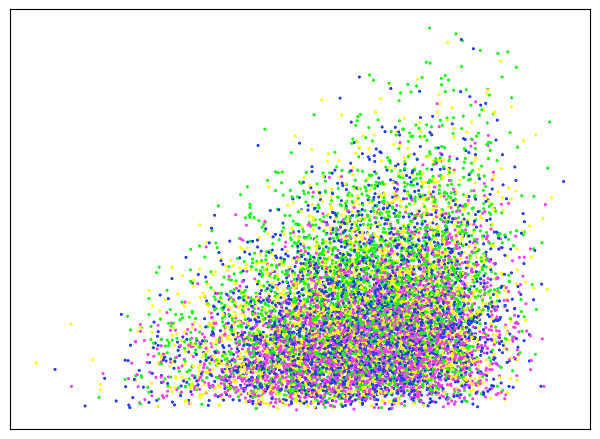

In [32]:
plt.scatter2d(infinitesimal_distances, c=infinitesimal_di_labels, cmap=Pmap, s=1)
if SAVE_EXTRAS:
    plt.save(g_Base() + "MfvHypersphereSample/InfinitesimalDistances")

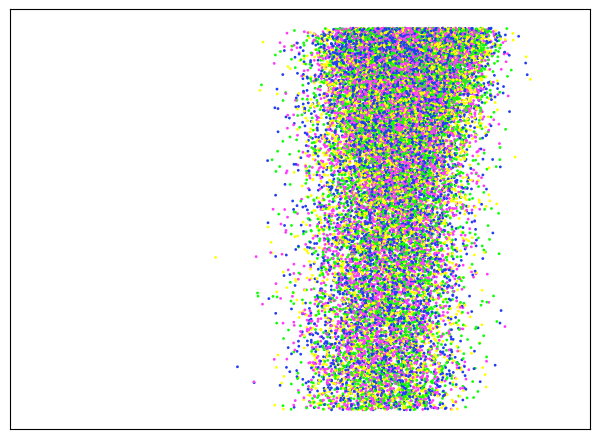

In [33]:
plt.scatter2d(infinitesimal_dots, c=infinitesimal_do_labels, cmap=Pmap, s=1)
plt.xlim([0,np.pi])
if SAVE_EXTRAS:
    plt.save(g_Base() + "MfvHypersphereSample/InfinitesimalAngles")

In [34]:
all_resampled_dataset = resampled_dataset.reshape((-1,13))
all_resampled_labels = resampled_labels.reshape((-1))
all_infinitesimal_distances, all_infinitesimal_labels = DistanceCovariance(model, all_resampled_dataset, all_resampled_labels, shuffle=True)

  0%|          | 0/2880 [00:00<?, ?it/s]

In [35]:
all_infinitesimal_distances.shape

(8291520, 2)

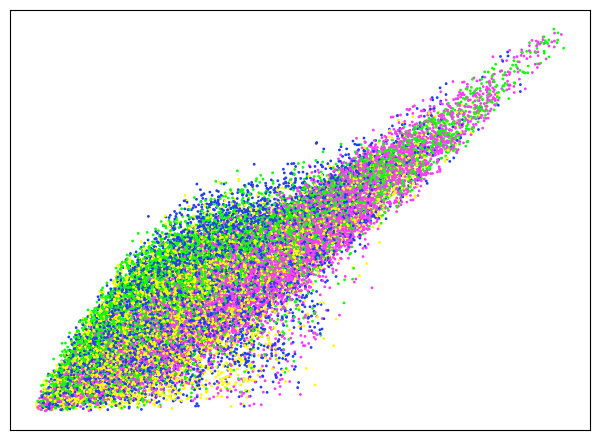

In [37]:
permutation = np.random.permutation(all_infinitesimal_distances.shape[0])
permutation = permutation[:g_permute_max(permutation)]
plt.scatter2d(all_infinitesimal_distances[permutation], c=all_infinitesimal_labels[permutation], cmap=Pmap, s=1)
_ = _
if SAVE_EXTRAS:
    plt.save(g_Base() + "MfvHypersphereSample/Distances")

In [38]:
all_infinitesimal_dots, all_infinitesimal_labels_do = AngleCovariance(model, all_resampled_dataset, all_resampled_labels, filter_R=2.01*g_d_Sampled, shuffle=True)

  0%|          | 0/2880 [00:00<?, ?it/s]

/tmp/4103233.6.sun-gpu.q/ipykernel_23558/659413713.py:102: RuntimeWarning: invalid value encountered in arccos
  return np.arccos(neighborhood_dot_products), neighborhood_labels


In [39]:
all_infinitesimal_dots.shape

(352305, 2)

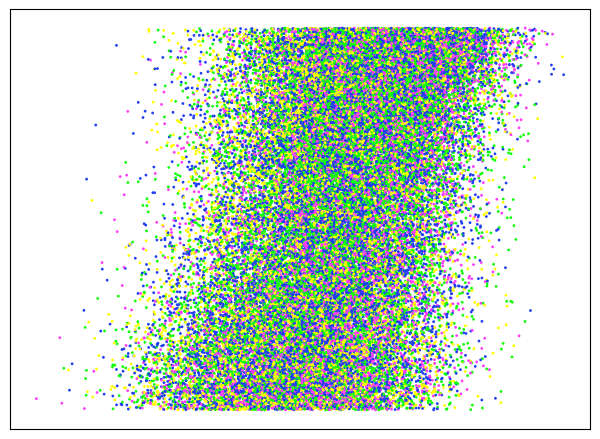

In [41]:
permutation = np.random.permutation(all_infinitesimal_dots.shape[0])
permutation = permutation[:g_permute_max(permutation)]
plt.scatter2d(all_infinitesimal_dots[permutation], c=all_infinitesimal_labels_do[permutation], cmap=Pmap, s=1)
_ = _
if SAVE_EXTRAS:
    plt.save(g_Base() + "MfvHypersphereSample/Angles")

# Latent Space Circles

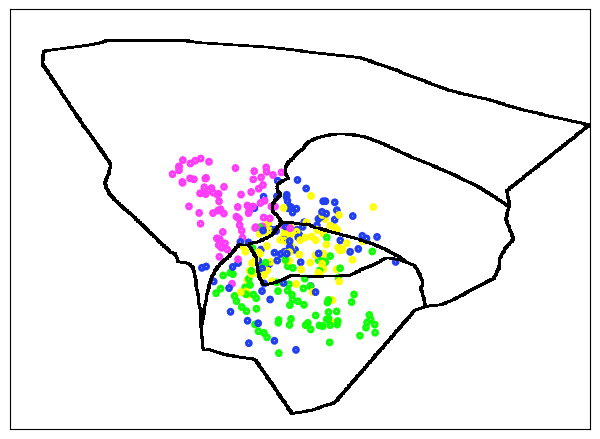

In [42]:
sampled_latent = model.encoder(sampled_dataset).numpy()
resampled_latent, resampled_labels = star_sample(sampled_latent, sampled_labels, N=g_N_Sampled, distance=g_d_Sampled, include_original=g_o_Sampled)
resampled_dataset = model.decoder(resampled_latent).numpy()
plt.scatter2d(resampled_latent.reshape((-1,2)), c=resampled_labels.reshape((-1)), cmap=Pmap, s=2)
plt.apply_boundary()
if SAVE_EXTRAS:
    plt.save(g_Base() + "MlvCircleSample/Latent")

In [51]:
infinitesimal_distances = []
infinitesimal_labels = []
for m in range(resampled_dataset.shape[0]):
    distance, labels = DistanceCovariance(model, resampled_dataset[m], resampled_labels[m], shuffle=True, silent=True)
    infinitesimal_distances.append(distance)
    infinitesimal_labels.append(labels)
infinitesimal_distances = np.vstack(infinitesimal_distances)
infinitesimal_labels_di = np.vstack(infinitesimal_labels)
infinitesimal_distances.shape

(23040, 2)

In [52]:
infinitesimal_dots = []
infinitesimal_labels = []
for m in range(resampled_dataset.shape[0]):
    dots, labels = AngleCovariance(model, resampled_dataset[m], resampled_labels[m], shuffle=True, silent=True)
    infinitesimal_dots.append(dots)
    infinitesimal_labels.append(labels)
infinitesimal_dots = np.vstack(infinitesimal_dots)
infinitesimal_labels_do = np.vstack(infinitesimal_labels)
infinitesimal_dots.shape

(26880, 2)

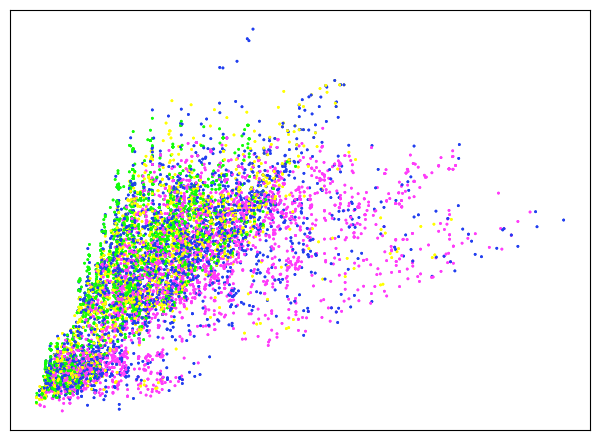

In [53]:
plt.scatter2d(infinitesimal_distances, c=infinitesimal_labels_di, cmap=Pmap, s=1)
if SAVE_EXTRAS:
    plt.save(g_Base() + "MlvCircleSample/InfinitesimalDistances")

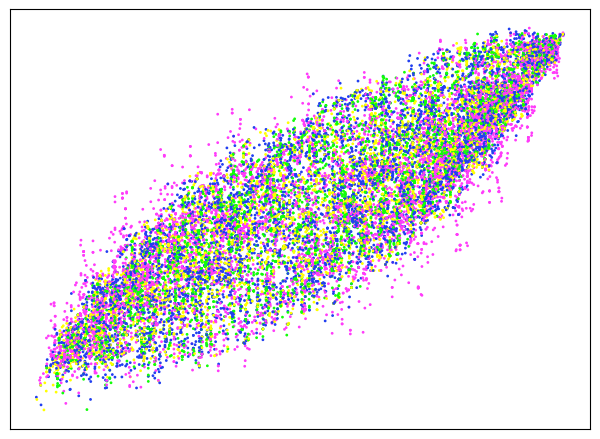

In [54]:
plt.scatter2d(infinitesimal_dots, c=infinitesimal_labels_do, cmap=Pmap, s=1)
if SAVE_EXTRAS:
    plt.save(g_Base() + "MlvCircleSample/InfinitesimalAngles")

In [55]:
distances, di_labels = DistanceCovariance(model, sampled_dataset, sampled_labels, shuffle=True)

  0%|          | 0/320 [00:00<?, ?it/s]

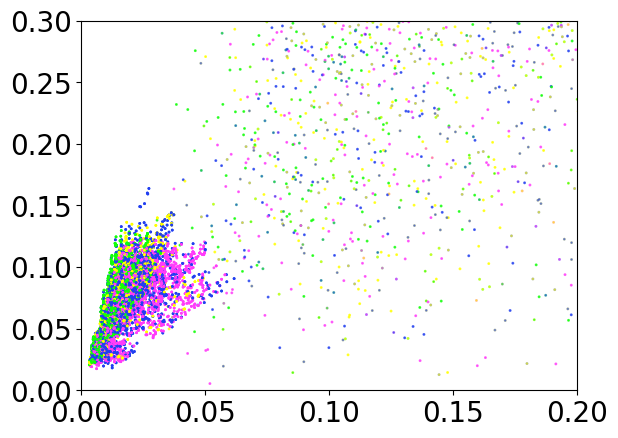

In [57]:
plt.scatter2d(distances, c=di_labels, cmap=Pmap, s=1, alpha=0.5)
plt.scatter2d(infinitesimal_distances, c=infinitesimal_labels_di, cmap=Pmap, s=1)
plt.xlim([0,0.2])
plt.ylim([0,0.3])
_ = _

In [58]:
all_resampled_dataset = resampled_dataset.reshape((-1,13))
all_resampled_labels = resampled_labels.reshape((-1))
all_infinitesimal_distances, all_infinitesimal_labels = DistanceCovariance(model, all_resampled_dataset, all_resampled_labels, shuffle=True)

  0%|          | 0/2880 [00:00<?, ?it/s]

In [59]:
all_infinitesimal_distances.shape

(8291520, 2)

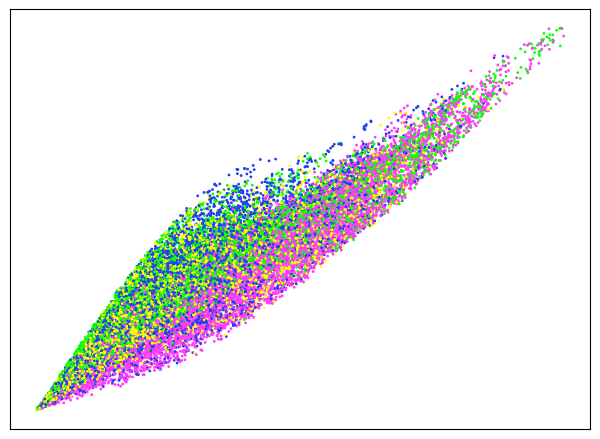

In [61]:
permutation = np.random.permutation(all_infinitesimal_distances.shape[0])
permutation = permutation[:g_permute_max(permutation)]
plt.scatter2d(all_infinitesimal_distances[permutation], c=all_infinitesimal_labels[permutation], cmap=Pmap, s=1)
_ = _
if SAVE_EXTRAS:
    plt.save(g_Base() + "MlvCircleSample/Distances")

In [62]:
all_infinitesimal_dots, all_infinitesimal_labels_do = AngleCovariance(model, all_resampled_dataset, all_resampled_labels, filter_R=2.01*g_d_Sampled, shuffle=True)

  0%|          | 0/2880 [00:00<?, ?it/s]

/tmp/4103233.6.sun-gpu.q/ipykernel_23558/659413713.py:102: RuntimeWarning: invalid value encountered in arccos
  return np.arccos(neighborhood_dot_products), neighborhood_labels


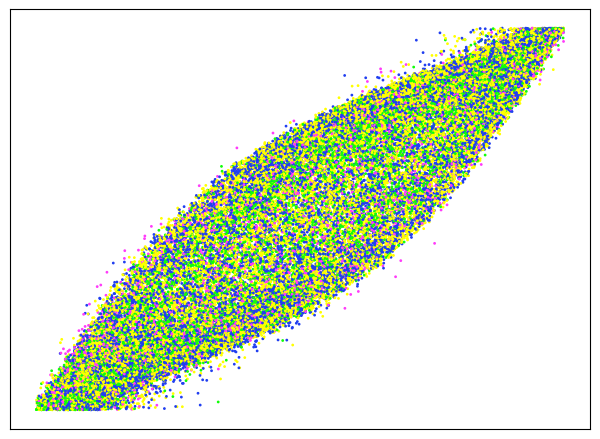

In [63]:
permutation = np.random.permutation(all_infinitesimal_dots.shape[0])
permutation = permutation[:g_permute_max(permutation)]
plt.scatter2d(all_infinitesimal_dots[permutation], c=all_infinitesimal_labels_do[permutation], cmap=Pmap, s=1)
if SAVE_EXTRAS:
    plt.save(g_Base() + "MlvCircleSample/Angles")

In [66]:
permutation = np.random.permutation(all_infinitesimal_dots.shape[0])
permutation = permutation[:g_permute_max(permutation)]
plt.scatter2d(all_infinitesimal_dots, c=all_infinitesimal_labels_do, cmap=Pmap, s=1)
if SAVE_EXTRAS:
    plt.save(g_Base() + "MlvCircleSample/Angles_all")

Exception ignored in: <function tqdm.__del__ at 0x2aaaeb997e50>
Traceback (most recent call last):
  File "/home/physics/cunnichr/.conda/envs/tfnb/lib/python3.9/site-packages/tqdm/std.py", line 1144, in __del__
    def __del__(self):
KeyboardInterrupt: 

KeyboardInterrupt



Error in callback <function flush_figures at 0x2aaae8c18d30> (for post_execute):



KeyboardInterrupt



# END